# Predict survival on the Titanic

>author:    
>Yan Weichao (ID: 11849019  Job: code writing and report arrangement)  
>Xie Weicheng (ID: 11849341 Job: data analysis)   
>Created  on Jan 5 2019

  
   
   
   
   
   
   
   
   
   
### Quike Content Overview:
* Question Description
* Data Preprocess
    * Data selection and reduction
    * Loss data competation
* Data Visualization Analysis
* Machine Learning and Discuss
    * Logistic Regression
    * Random Forest

#### Required Libraries:
* [NumPy](http://www.numpy.org/)
* [IPython](http://ipython.org/)
* [Pandas](http://pandas.pydata.org/)
* [SciKit-Learn](http://scikit-learn.org/stable/)
* [SciPy](http://www.scipy.org/)
* [StatsModels](http://statsmodels.sourceforge.net/)
* [Patsy](http://patsy.readthedocs.org/en/latest/)
* [Matplotlib](http://matplotlib.org/)
* [Waringings](https://docs.python.org/3/library/warnings.html)

* ### Question Descciption

> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.  
  
> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.  
  
> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

More detailed description see the competition [homepage](https://www.kaggle.com/c/titanic/)

* ### Data preprocess

Before our formal processing, import some neccesary python libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm
from KaggleAux import predict as ka # see github.com/agconti/kaggleaux for more details
import warnings
warnings.filterwarnings('ignore')

Dataset provided by Google includes two parts: `train.csv` and `test.csv`.  
First we use pandas read data.

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Train data has 12 columns: PassengerId, Survivied, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked. These columns represent information just as what their meanings in words.  For machine learning only can process numerical data, we need to do some extra preprocess for some columns, such as 'Name','Sex', etc.
  
But don't worry, we have a overview of these data first.

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Now we know that, train_data has some values missed in 'Age' column and much values missed in 'Cabin' column. We have a `more information remained` principle in data processing. So we can fill the empty(NaN) with mean value or medium value or something else in 'Age' column to remain more information, but for 'Cabin' Column, due to too much value missed, empty filling can decrease the feature confidence. Dropping 'Cabin' column would be a better choice. The same principle can be used in test_data.   

So far, we get a pseudo equation about target and features: 'Survival' ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked). We believe that ` C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)` are features directly related to the survival results, which are also used in later machine learning analysis. Here, C() means cateory variable, that is, we regard Pclass1/2/3 as three different categories without multipal/times relationship. `~` means an extensive relationship.


##### data selection / reduction

In [6]:
# select features used in machine learning
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_train = train_data[features]
x_test = test_data[features]

y_train=train_data['Survived']

##### Missing data completion

In [7]:
# Use the average age to fill the nan value in the 'age' column
x_train['Age'].fillna(x_train['Age'].mean(), inplace=True)
x_test['Age'].fillna(x_test['Age'].mean(),inplace=True)

# Use the average fare to fill the nan value in the 'Fare' column
x_test['Fare'].fillna(x_test['Fare'].mean(),inplace=True)

`Embarked` is category data, taking the most frequently occurring categories to complete the null value.

In [8]:
# Use the port with the most login to fill the nan value of the login port
print (x_train['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [9]:
x_train['Embarked'].fillna('S', inplace=True)
x_test['Embarked'].fillna('S',inplace=True)

Now let's have a look at x_train and x_test after preprocessing

In [10]:
x_train.info()
print("-" * 50)
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 22.9+ KB


*Bingo! * Let's go to the next part: data visualization analysis.

* ### Data visualization analysis.

First let's have a overview of the relationship between survival and Pclass/Sex/Age (distribution)/SibSp/Parch/Fare (distribution)/Embarked.

In [11]:
fig = plt.figure(figsize=(24,12), dpi=1600) 

ax1 = fig.add_subplot(231)
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')
plt.title('How many people survived in train data (1 survival)')

ax2 = fig.add_subplot(232)
sns.countplot('Pclass', hue='Survived', data=train_data)
plt.title('people survived in every Pclass')

ax3 = fig.add_subplot(233)
sns.countplot('Sex', hue='Survived', data=train_data)

ax4 = fig.add_subplot(234)
sns.countplot('SibSp', hue='Survived', data=train_data)

ax5 = fig.add_subplot(235)
sns.countplot('Parch', hue='Survived', data=train_data)

ax6 = fig.add_subplot(236)
sns.countplot('Embarked', hue='Survived', data=train_data)

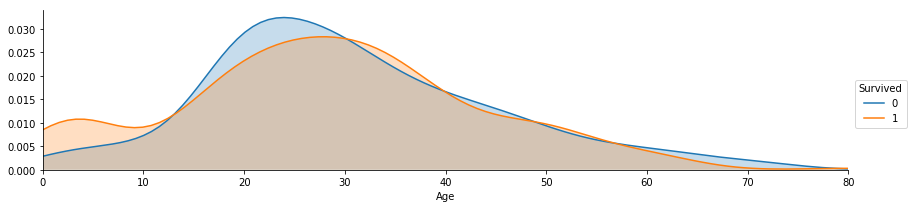

In [12]:
# observe age distribution in survival
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

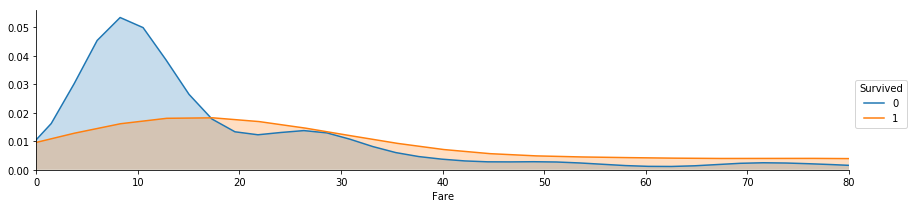

In [13]:
# observe Fare distribution in survival
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

Not surprisingly, `Pclass_1`,`women` have bigger survival probability than other persons. No SibSp or Parch is bad, however, a person who has too many SibSp or Parch can also decrease survival rate. Considering most people in Titanic are young, we can't get a absolute/clear relationship between survival and age. But for fare, low fare price is incline to low survival.

###### We can tease more structure out of data, by analysing several features together.  

Here we combine age and Pclass in survival, sex and age in survival respectively.

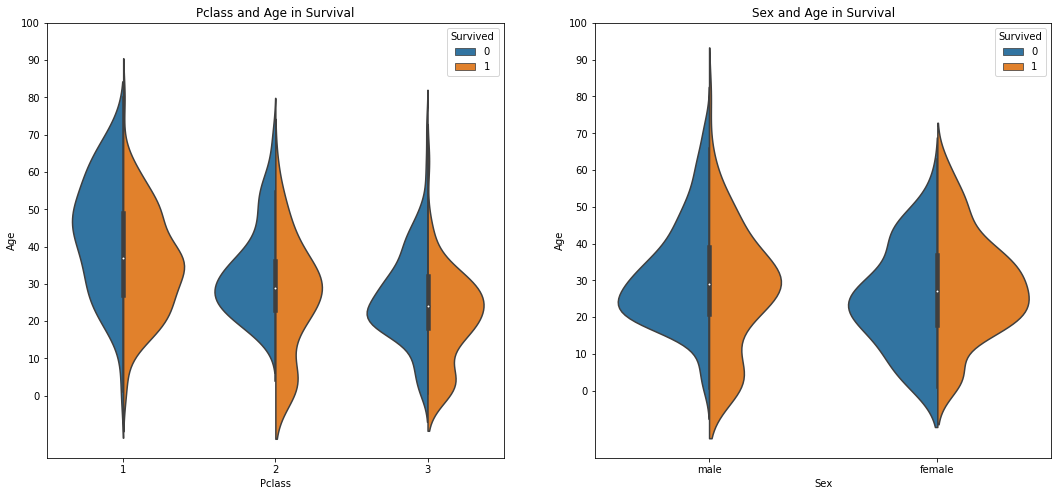

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age in Survival')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age in Survival')
ax[1].set_yticks(range(0, 110, 10))

`SibSp` and `Parch` features are simular. We can combine these two features as `Family_Size`

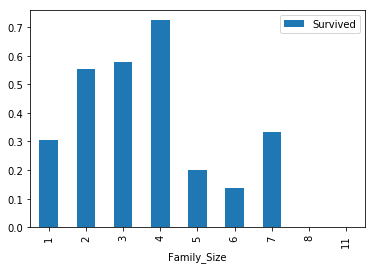

In [15]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()

This figure shows relationship between family size and survival rate more clearly! 


From above analysis, we know that Pclass_1 and women have bigger survival rate. But Pclass_1&man VS. Pclass_2/3&woman, who is more lucky?

In [16]:
fig = plt.figure(figsize=(18,12), dpi=1600)
ax7 = fig.add_subplot(241)
train_data.Survived.value_counts().plot(kind='bar', color="blue", alpha=.65)
ax7.set_xlim(-1, len(train_data.Survived.value_counts()))


ax8 = fig.add_subplot(245)
female_highclass = train_data.Survived[train_data.Sex == 'female'][train_data.Pclass != 3].value_counts()
female_highclass.plot(kind='bar', label='female highclass', color='#FA2479', alpha=0.65)
ax8.set_xticklabels(["Survived", "Died"], rotation=0)
ax8.set_xlim(-1, len(female_highclass))
plt.title("Who Survived? with respect to Gender and Class"); plt.legend(loc='best')

ax9 = fig.add_subplot(246, sharey=ax7)
female_lowclass = train_data.Survived[train_data.Sex == 'female'][train_data.Pclass == 3].value_counts()
female_lowclass.plot(kind='bar', label='female, low class', color='pink', alpha=0.65)
ax9.set_xticklabels(["Died","Survived"], rotation=0)
ax9.set_xlim(-1, len(female_lowclass))
plt.legend(loc='best')

ax10 = fig.add_subplot(247, sharey=ax7)
male_lowclass = train_data.Survived[train_data.Sex == 'male'][train_data.Pclass == 3].value_counts()
male_lowclass.plot(kind='bar', label='male, low class',color='lightblue', alpha=0.65)
ax10.set_xticklabels(["Died","Survived"], rotation=0)
ax10.set_xlim(-1, len(male_lowclass))
plt.legend(loc='best')

ax11 = fig.add_subplot(248, sharey=ax7)
male_highclass = train_data.Survived[train_data.Sex == 'male'][train_data.Pclass != 3].value_counts()
male_highclass.plot(kind='bar', label='male highclass', alpha=0.65, color='steelblue')
ax11.set_xticklabels(["Died","Survived"], rotation=0)
ax11.set_xlim(-1, len(male_highclass))
plt.legend(loc='best')

THe question(Pclass_1&man VS. Pclass_2/3&woman) answer: almost equal.  Noblewomen has absolute adwantage!

More analysis could be better. It's time for machine learning. Here we use logistic regression, SVM, and Random Forest.

* ### Machine Learning and Discuss

   #### Logistic Regression

> In statistics, the logistic model (or logit model) is a widely used statistical model that, in its basic form, uses a logistic function to model a binary dependent variable; many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model; it is a form of binomial regression.

From [wikipedia](https://en.wikipedia.org/wiki/Logistic_regression)
  
We notice that logistic regression is used in two-type classification. And a good news is that Titanic problem belongs to it: survival(1) or died(0). So we can use this method directly.  
In logistic regression, we try to arrange coeffective for every variable. Then we can get a sum result as this formal: y = a·x(1) + b·x(2) + c·x(3) + ... + n·x(n). To transform the sum result as classifiction judgment, people use a `sigmoid function`, which can map a number (range from -Inf to Inf) into another one (range from a to b, generally, a = 0 and b = 1). Here we show the function figure:

![sigmoid function formula](https://github.com/stevenzolo/SML_hw/blob/master/finalTest/SML-titanic/images/sigmoid_math.png)  
![sigmoid function graph](https://github.com/stevenzolo/SML_hw/blob/master/finalTest/SML-titanic/images/sigmoid_function.jpg)

Not surprisingly, `0` and `1` represent two types of classification we try to assess. But there is still a question: how can we go from a rational number (0-1) to a integer one (0 or 1)? What about choose a boundary like 0.5? It seems well. But why is 0.5? Why is not 0.49 or 0.51? Obviously it is depend on users. Experience can not convince everyone. Therefore, we try to use a more scientific method: iteration.
  
The three cells below show the process of creating our Logitist regression model, training it on the data, and examining its performance.  

First, we define our formula for our Logit regression. In the next cell we create a regression friendly dataframe that sets up boolean values for the categorical variables in our formula and lets our regression model know the types of inputs we're giving it. The model is then instantiated and fitted before a summary of the model's performance is printed. In the last cell we graphically compare the predictions of our model to the actual values we are trying to predict, as well as the residual errors from our model to check for any structure we may have missed.

In [17]:
# model formula
# Ref: http://patsy.readthedocs.org/en/latest/formulas.html
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)' 
# create a results dictionary to hold our regression results for easy analysis later        
results = {}

In [18]:
# create a regression friendly dataframe using patsy's dmatrices function
y,x = dmatrices(formula, data=train_data, return_type='dataframe')

# instantiate our model
model = sm.Logit(y,x)

# fit our model to the training data
res = model.fit()

# save the result for outputing predictions later
results['Logit'] = [res, formula]
res.summary()

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Thu, 03 Jan 2019   Pseudo R-squ.:                  0.3419
Time:                        22:49:17   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
                                        LLR p-value:                 2.249e-65
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.4329      0.536      8.271      0.000       3.383       5.483
C(Pclass)[T.2]      -1.1896      0.329     -3.614      0.000      -1.835      -0.544
C(Pclass)[T.3]      -2.3952      0.343     -6.976      0.000      -3.068      -1.722
C(Sex)[T.male]      -2.6379      0.223    -11.829      0.000      -3.075      -2.201
C(Embarked)[T.Q]    -0.8234      0.600     -1.372      0.170      -2.000       0.353
C(Embarked)[T.S]    -0.4028      0.275     -1.467      0.142      -0.941       0.135
Age                 -0.0433      0.008     -5.204      0.000      -0.060      -0.027
SibSp               -0.3629      0.129     -2.807      0.005      -0.616      -0.110
Parch               -0.0604      0.124     -0.487      0.626      -0.303       0.183
Fare                 0.0015      0.003      0.559      0.576      -0.004       0.007
====================================================================================
"""

Now we have got the optimized function value and some other useful information. Here, observations mean person data used in iteration, which are generated from five-fold validation. MLE is abbreviation of the regression core, maximum likelihood estimation. MLE is a method of estimating the parameters of a statistical model. More details about it are suggested to read [wikipedia](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). In the table below, the results have displayed coefficients of each variable respectively. Intercept means coefficients of constant 1, just like in linear function. And wider confidence interval located in the last two columns indicates a more robust of the regression model.   

If you have pay attention to the parameter difference between the initial model and the results, you will find something lost. Yes! The results always lost one of `catogary variables`. Why? [Dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) can answer this question. In the panel data, fixed effects estimator dummies are created for each of the units in cross-sectional data (e.g. firms or countries) or periods in a pooled time-series. However in such regressions either the constant term has to be removed or one of the dummies has to be removed, with its associated category becoming the base category against which the others are assessed in order to avoid the dummy variable trap.  



After evaluating the boundary, we get back to titanic problem and check the classifation results.

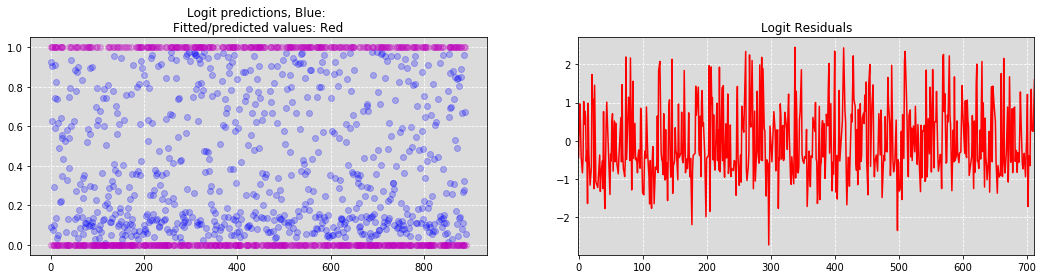

In [19]:
# Plot Predictions Vs Actual
plt.figure(figsize=(18,4));
plt.subplot(121, facecolor="#DBDBDB")
# generate predictions from our fitted model
ypred = res.predict(x)
plt.plot(x.index, ypred, 'bo', x.index, y, 'mo', alpha=.25);
plt.grid(color='white', linestyle='dashed')
plt.title('Logit predictions, Blue: \nFitted/predicted values: Red');

# Residuals
ax2 = plt.subplot(122, facecolor="#DBDBDB")
plt.plot(res.resid_dev, 'r-')
plt.grid(color='white', linestyle='dashed')
ax2.set_xlim(-1, len(res.resid_dev))
plt.title('Logit Residuals');

We can also check how accurate the logistic model fitted with original train data.

In [20]:
# convert rational value range in 0-1 into judgmentation
ypred_list = list(ypred)
yjudge = [0]* len(ypred_list)
for index1 in range(len(ypred_list)):
    if ypred_list[index1] > 0.444:
        yjudge[index1] = 1
        
# compare the survival calculated by model and the ground truth
# return the accurate rate
err = 0
for index2 in range(len(ypred_list)):
    if list(y['Survived'])[index2] != yjudge[index2]:
        err += 1
accu_rate = 1 - err/len(ypred_list)
print('accu_rate: ', accu_rate)

accu_rate:  0.797752808988764


#### Now  we apply our model in test data and output the prediction result.

In [21]:
# Add our independent variable to our test data
x_test['Survived'] = 1.23
results 

{'Logit': [<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x215fea62908>,
  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)']}

In [22]:
# Use model to make prediction on our test set. 
compared_resuts = ka.predict(x_test, results, 'Logit')
y_test = [0] * len(compared_resuts)
index3 = 0
for value in compared_resuts:
    if value > 0.444:
        y_test[index3] = 1
    index3 += 1
y_test = Series(y_test)  # convert our model to a series for easy output
# output and submit to kaggle
y_test.to_csv("data/output/logitregrestt.csv")

![kaggle score](https://github.com/stevenzolo/SML_hw/blob/master/finalTest/SML-titanic/images/logregScore.png)

#### Results as scored by Kaggle : 0.76555.  We can do better !

#### Random Forest

In the analysis above, we assume that survival and death boundary can be expressed by a straight line. Well, What if this line boundary doesn’t work at all. We would like to use another method: Random Forest.

> Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees' habit of overfitting to their training set.

From [wikipedia](https://en.wikipedia.org/wiki/Random_forest)

In [23]:
# import the machine learning library that holds the randomforest
import sklearn.ensemble as ske

# Create the random forest model and fit the model to our training data
y, x = dmatrices(formula, data=train_data, return_type='dataframe')
# RandomForestClassifier expects a 1 demensional NumPy array, so we convert
y = np.asarray(y).ravel()
#instantiate and fit our model
results_rf = ske.RandomForestClassifier(n_estimators=100).fit(x, y)

# Score the results
score = results_rf.score(x, y)
print ("Mean accuracy of Random Forest Predictions on the data was: {0}".format(score))

Mean accuracy of Random Forest Predictions on the data was: 0.9859550561797753


In [24]:
test_data = pd.read_csv('data/test.csv')
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
x_test = test_data[features]
x_test['Age'].fillna(x_test['Age'].mean(),inplace=True)
x_test['Fare'].fillna(x_test['Fare'].mean(),inplace=True)
x_test['Embarked'].fillna('S',inplace=True)
x_test['Survived'] = 1.23
results

{'Logit': [<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x215fea62908>,
  'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)']}

In [25]:
y, x = dmatrices(formula, data=x_test, return_type='dataframe')

In [26]:
y_test = results_rf.predict(x)
y_test = Series(y_test)
y_test.to_csv("data/output/logitregres_rfm.csv")